# Lesson 1 Bresenham’s Line Drawing Algorithm

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from skimage.io import imread
import cv2

In [14]:
red = [255, 0, 0]
green = [0, 255, 0]
white = [255, 255, 255]

In [15]:
def line(p0, p1, plane, color):
    trans = False
    if np.abs(p0[0] - p1[0]) < np.abs(p0[1] - p1[1]):
        p0 = p0[::-1]
        p1 = p1[::-1]
        trans = True
        
    if p0[0] > p1[0]:
        p0, p1 = p1, p0
    
    for x in np.arange(p0[0], p1[0], 1):
        t = (x-p0[0])/(p1[0]-p0[0]) 
        y = int(p0[1]*(1. - t) + p1[1]*t)
        if trans:
            plane[y,x] = color
        else:
            plane[x,y] = color
            
    return plane

In [14]:
plane = np.zeros((100,100,3))
plane = line([13, 20], [80, 40], plane, red)
plane = line([20, 13], [40, 80], plane, white)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


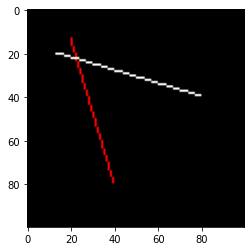

In [15]:
plt.imshow(plane)

-----

In [16]:
def parse_obj(pth, return_z = False):
    with open(pth) as f:
        lines = f.readlines()

    vert = [x for x in lines if x.startswith('v ')]
    vert = [list(map(float, x[1:].strip().split())) for x in vert]

    faces = [x for x in lines if x.startswith('f')]
    faces = [[x.split('/')[0].split()[1], x.split('/')[2].split()[1], x.split('/')[4].split()[1]]
             for x in faces]
    faces = [[int(y) - 1 for y in x] for x in faces]

    triangles = []
    for cur_face in faces:
        pts = []
        for cur_vert in cur_face:
            if return_z:
                pts.append(vert[cur_vert])
            else:
                pts.append(vert[cur_vert][:-1])

        triangles.append(pts)

    return triangles

In [22]:
width  = 800;
height = 800;

In [18]:
triangles = parse_obj('obj/african_head.obj')
plane = np.zeros((width,height,3))

In [19]:
for cur_trian in triangles:
    for idx, cur_pts in enumerate(cur_trian):
        pt_1 = cur_pts[:]
        pt_2 = cur_trian[(idx+1)%3][:]
        
        pt_1[0] = int(pt_1[0] * width/2 + width/2)
        pt_2[0] = int(pt_2[0] * width/2 + width/2)
        
        pt_1[1] = -int(pt_1[1] * height/2 + height/2)
        pt_2[1] = -int(pt_2[1] * height/2 + height/2)
        
        line(pt_1[::-1], pt_2[::-1], plane, white)

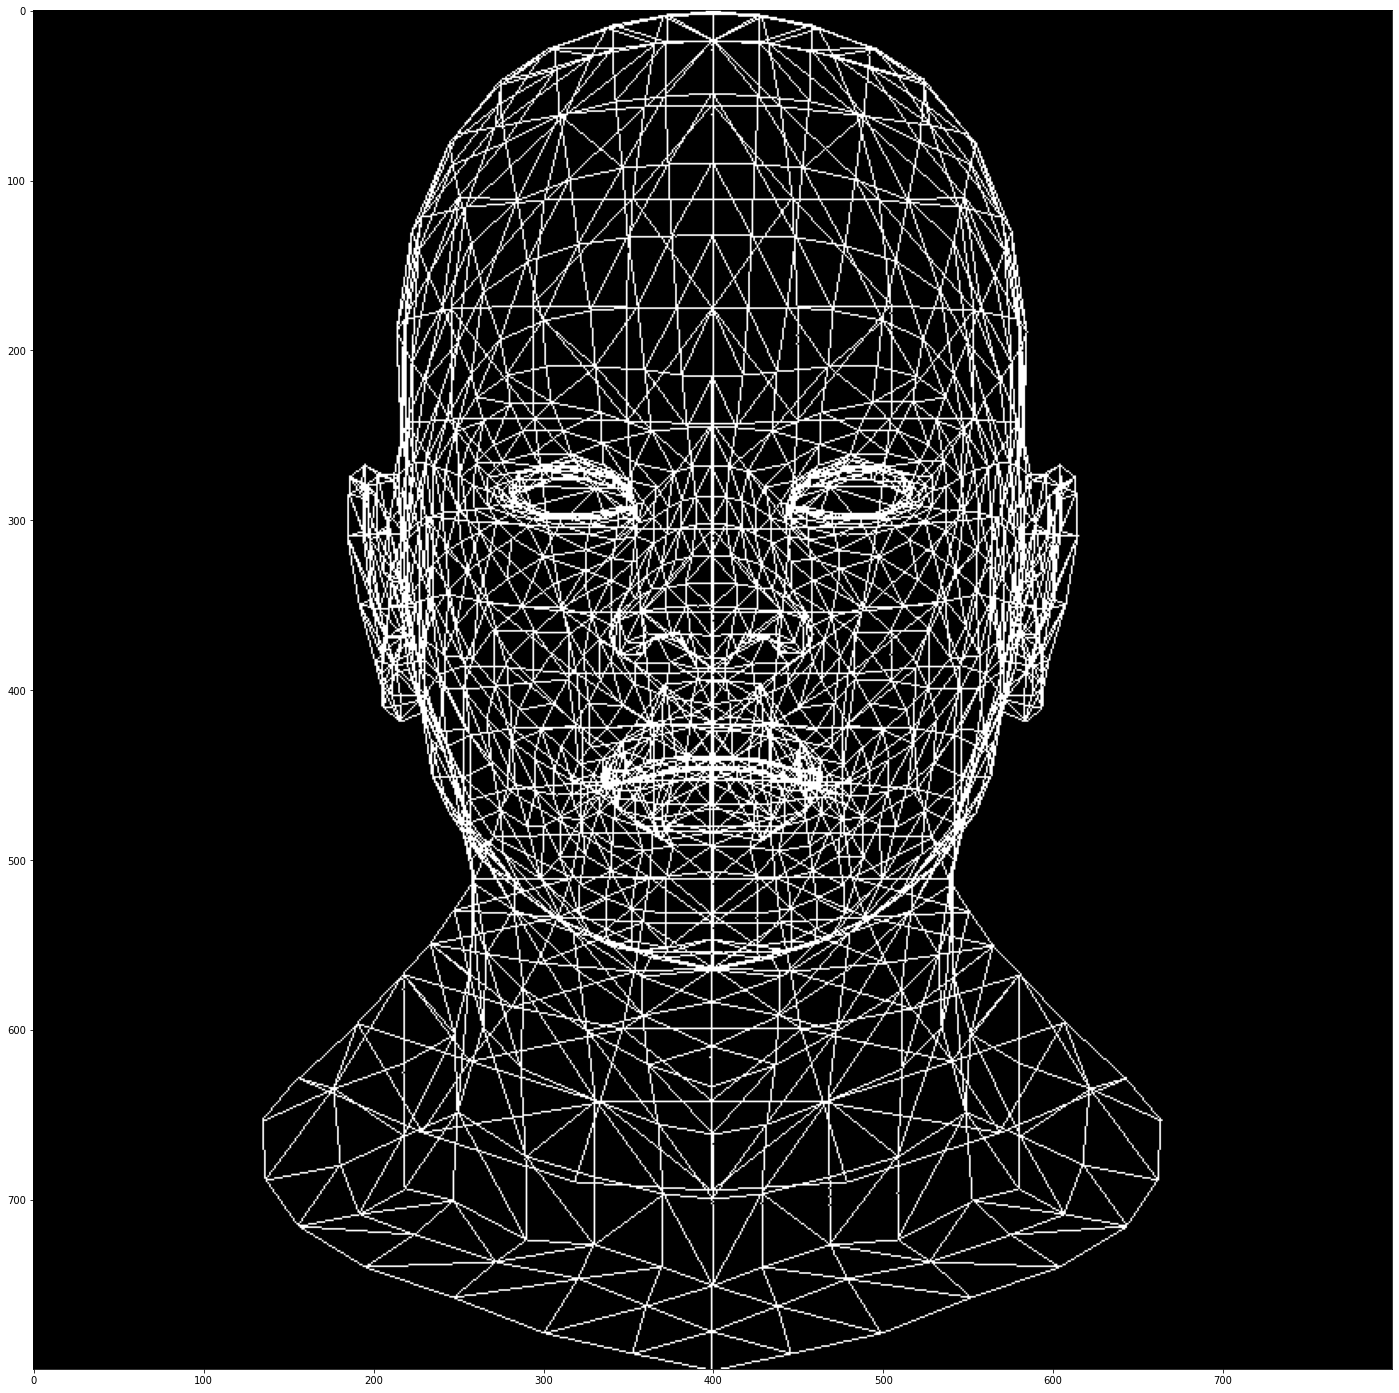

In [20]:
plt.figure(figsize=(25,25))
plt.imshow(plane.astype('int32'))

# Lesson 2 Triangle rasterization and back face culling


In [1]:
def draw_triangle(p0, p1, p2, plane, color):
    plane = line(p0, p1, plane, color)
    plane = line(p1, p2, plane, color)
    plane = line(p2, p0, plane, color)
    return plane

In [2]:
def get_trian_bbox(p0, p1, p2):
    bbox_y = [np.inf, 0]
    bbox_x = [np.inf, 0]
    for cur_p in [p0, p1, p2]:
        bbox_y[0] = int(min(cur_p[1], bbox_y[0]))
        bbox_y[1] = int(max(cur_p[1], bbox_y[1]))

        bbox_x[0] = int(min(cur_p[0], bbox_x[0]))
        bbox_x[1] = int(max(cur_p[0], bbox_x[1]))
    return bbox_x, bbox_y

In [3]:
def fill_bbox(bbox_x, bbox_y, plane, color):
    for cur_x in np.arange(bbox_x[0], bbox_x[1]+1):
        for cur_y in np.arange(bbox_y[0], bbox_y[1]+1):
            plane[cur_x, cur_y] = color
    return plane

In [4]:
def is_in_trian(p0, p1, p2, new_p, precomp_t_inv=None, ):
    if precomp_t_inv is not None:
        T = precomp_t_inv
    else:
        T = np.array([
            [p0[0] - p2[0], p1[0] - p2[0]],
            [p0[1] - p2[1], p1[1] - p2[1]],
        ])
        T = np.linalg.inv(T)
    try:
        l1, l2 = T.dot( np.array(new_p) - np.array(p2))
        l3 = 1 - l1 - l2
#         print(l1, l2, l3)
        return (l1>=0) and (l2>=0) and (l3>=0)
    except:
        return False

In [5]:
def fill_triangle(p0, p1, p2, plane, color):
    bbox_x, bbox_y = get_trian_bbox(p0, p1, p2)
    
    precomp_t_inv = np.linalg.inv(np.array([
            [p0[0] - p2[0], p1[0] - p2[0]],
            [p0[1] - p2[1], p1[1] - p2[1]],]))
    
    for cur_x in np.arange(bbox_x[0], bbox_x[1]+1):
        for cur_y in np.arange(bbox_y[0], bbox_y[1]+1):
            if is_in_trian(p0, p1, p2, [cur_x, cur_y], precomp_t_inv=precomp_t_inv):
                plane[cur_x, cur_y] = color
    return plane

In [23]:
def fill_triangle(p0, p1, p2, plane, color):
    bbox_x, bbox_y = get_trian_bbox(p0, p1, p2)
    
    try:
        precomp_t_inv = np.linalg.inv(np.array([
                [p0[0] - p2[0], p1[0] - p2[0]],
                [p0[1] - p2[1], p1[1] - p2[1]],]))
    except:
        return plane

    mesh_grid = np.meshgrid(np.arange(bbox_x[0], bbox_x[1]+1), 
                        np.arange(bbox_y[0], bbox_y[1]+1))
    
    grid = np.stack([mesh_grid[0].T, mesh_grid[1].T])
    grid = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T

    barycent = precomp_t_inv.dot(grid.T - np.array(p2)[:,None])
    barycent = np.concatenate([barycent, 1-barycent.sum(axis=0)[None]])

    good_pts = np.product(np.round(barycent,2)>=-0, axis=0)

    plane[grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]] = color
    return plane

In [24]:
plane = np.zeros((200,200,3))

In [25]:
plane = draw_triangle([10, 70], [50, 90], [70, 80], plane, red)
plane = draw_triangle([180, 50], [150, 1], [70, 180], plane, red)
plane = draw_triangle([180, 150], [120, 160], [130, 180], plane, red)

In [26]:
p0, p1, p2 = [10, 70], [50, 90], [70, 80]
plane = fill_triangle(p0, p1, p2, plane, red)

p0, p1, p2 = [180, 50], [150, 1], [70, 180]
plane = fill_triangle(p0, p1, p2, plane, red)

p0, p1, p2 = [180, 150], [120, 160], [130, 180]
plane = fill_triangle(p0, p1, p2, plane, red)

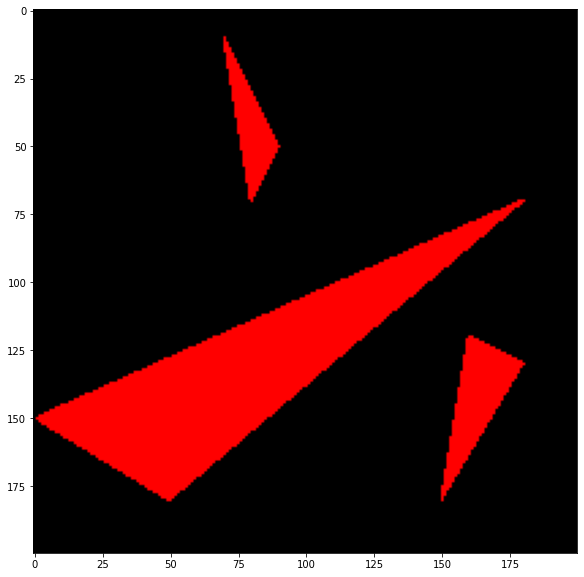

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(plane.astype('int32'))

-----

In [31]:
width  = 800;
height = 800;

In [32]:
triangles = parse_obj('obj/african_head.obj')
plane = np.zeros((width,height,3))

In [33]:
for cur_trian in triangles:
    for idx, cur_pts in enumerate(cur_trian):
        pt_1 = cur_pts[:]
        pt_2 = cur_trian[(idx+1)%3][:]
        
        pt_1[0] = int(pt_1[0] * width/2 + width/2)
        pt_2[0] = int(pt_2[0] * width/2 + width/2)
        
        pt_1[1] = - int(pt_1[1] * height/2 + height/2) 
        pt_2[1] = - int(pt_2[1] * height/2 + height/2)
        
        line(pt_1[::-1], pt_2[::-1], plane, white)

In [34]:
for idx, cur_trian in enumerate(tqdm_notebook(triangles)):
    for cur_idx in range(len(cur_trian)):
        cur_trian[cur_idx][0] = int((cur_trian[cur_idx][0] + 1) * width/2) 
        cur_trian[cur_idx][1] = - int((cur_trian[cur_idx][1] + 1) * height/2)
        cur_trian[cur_idx] = cur_trian[cur_idx][::-1]

    plane = fill_triangle(*cur_trian, plane, np.random.randint(0, 255, 3).tolist())
#     if idx > 50:
#         break

<ipython-input-34-a1c8b47f4d3d>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cur_trian in enumerate(tqdm_notebook(triangles)):


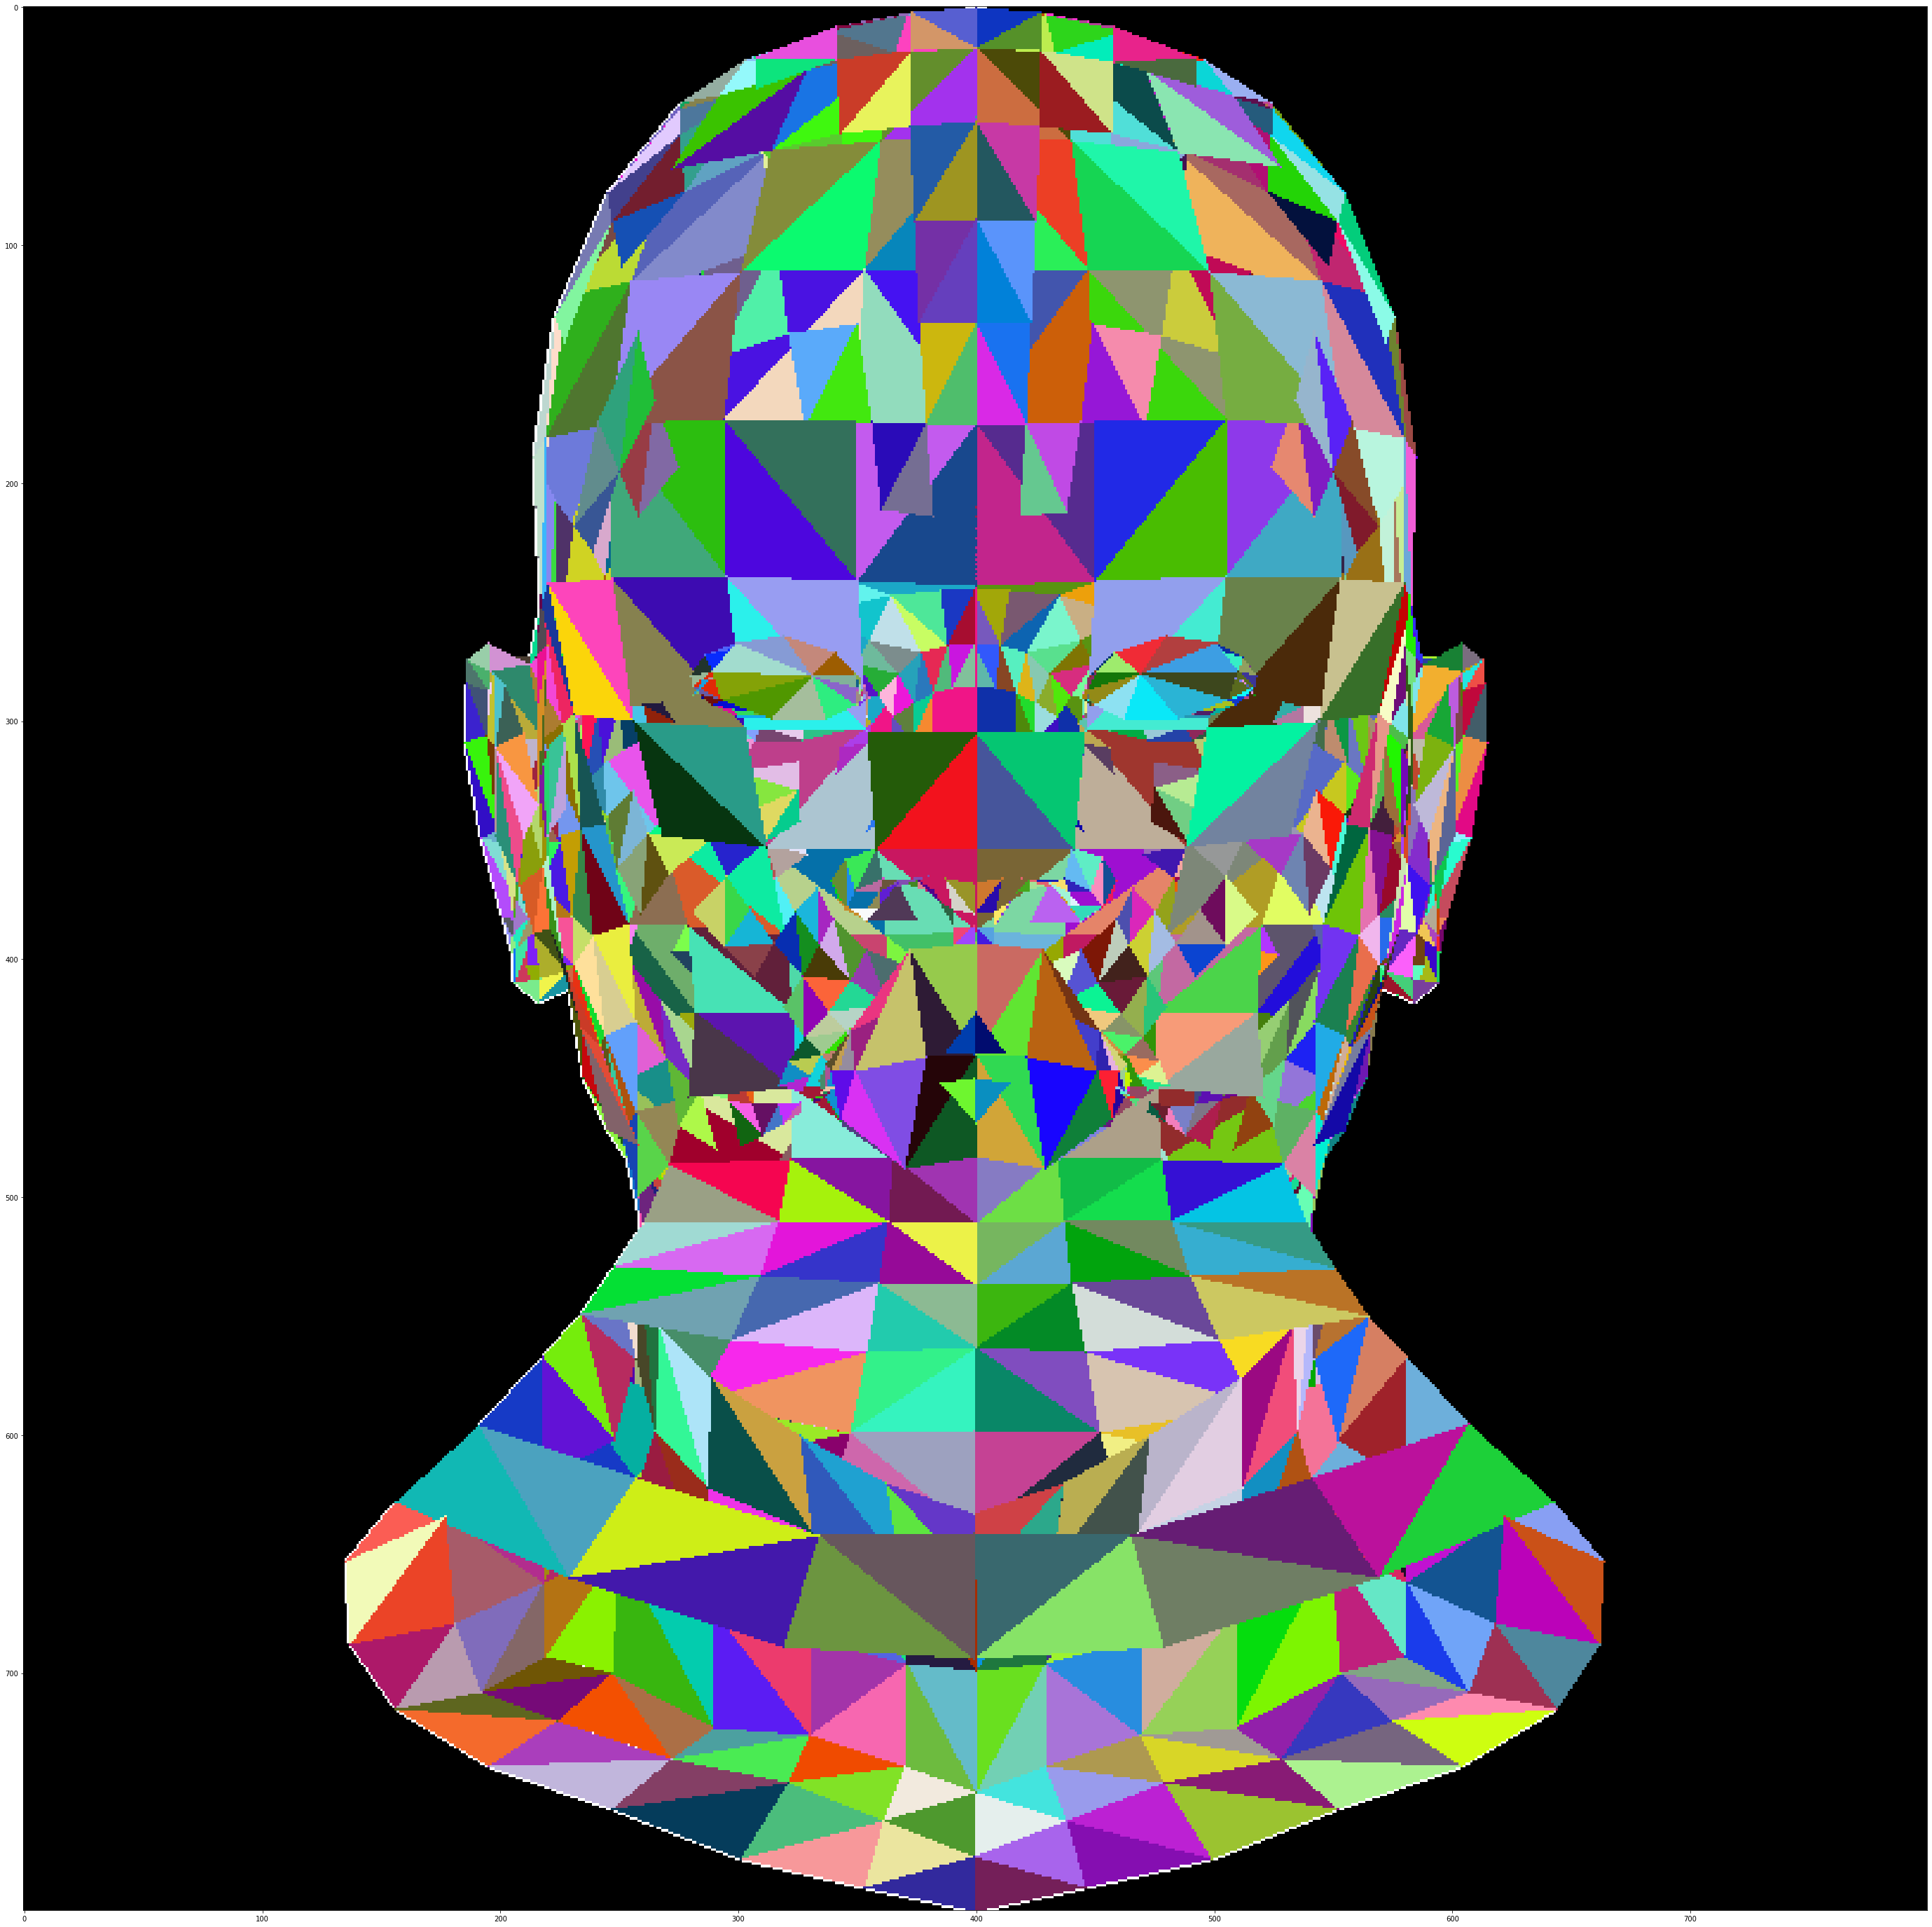

In [35]:
plt.figure(figsize=(50,50))
plt.imshow(plane.astype('int32'))

-----

In [32]:
width  = 800;
height = 800;
light_dir = np.array([0,0,-1])

In [33]:
triangles = parse_obj('obj/african_head.obj', False)
plane = np.zeros((width,height,3))

In [30]:
for cur_trian in triangles:
    for idx, cur_pts in enumerate(cur_trian):
        pt_1 = cur_pts[:]
        pt_2 = cur_trian[(idx+1)%3][:]
        
        pt_1[0] = int(pt_1[0] * width/2 + width/2)
        pt_2[0] = int(pt_2[0] * width/2 + width/2)
        
        pt_1[1] = - int(pt_1[1] * height/2 + height/2) 
        pt_2[1] = - int(pt_2[1] * height/2 + height/2)
        
        line(pt_1[::-1], pt_2[::-1], plane, white)

In [34]:
triangles = parse_obj('obj/african_head.obj', True)

In [40]:
for idx, cur_trian in enumerate(tqdm_notebook(triangles)):
    to_use_train = np.array(cur_trian)[:]
    norm = np.cross(to_use_train[2] - to_use_train[0], to_use_train[1] - to_use_train[0])
    norm = norm/np.linalg.norm(norm)   
    intens = (norm * light_dir).sum()
    cur_trian = np.array(cur_trian)[:,:2].tolist()
    
    if intens > 0:
        for cur_idx in range(len(cur_trian)):
            cur_trian[cur_idx][0] = int((cur_trian[cur_idx][0] + 1) * width/2) 
            cur_trian[cur_idx][1] = - int((cur_trian[cur_idx][1] + 1) * height/2)
            cur_trian[cur_idx][0], cur_trian[cur_idx][1] = cur_trian[cur_idx][1], cur_trian[cur_idx][0]

        plane = fill_triangle(*cur_trian, plane, [255*intens, 255*intens, 255*intens])
        
#         if idx > 50:
#             break

<ipython-input-40-d4b5cd69a984>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cur_trian in enumerate(tqdm_notebook(triangles)):


In [35]:
for idx, cur_trian in enumerate(tqdm_notebook(triangles)):
    to_use_train = np.array(cur_trian)[:]
    norm = np.cross(to_use_train[2] - to_use_train[0], to_use_train[1] - to_use_train[0])
    norm = norm/np.linalg.norm(norm)   
    intens = (norm * light_dir).sum()
    cur_trian = np.array(cur_trian)[:,:2].tolist()
    
    if intens > 0:
        for cur_idx in range(len(cur_trian)):
            cur_trian[cur_idx][0] = int((cur_trian[cur_idx][0] + 1) * width/2) 
            cur_trian[cur_idx][1] = - int((cur_trian[cur_idx][1] + 1) * height/2)
            cur_trian[cur_idx][0], cur_trian[cur_idx][1] = cur_trian[cur_idx][1], cur_trian[cur_idx][0]

        plane = fill_triangle(*cur_trian, plane, [255*intens, 255*intens, 255*intens])
        
#         if idx > 50:
#             break

<ipython-input-35-d4b5cd69a984>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cur_trian in enumerate(tqdm_notebook(triangles)):


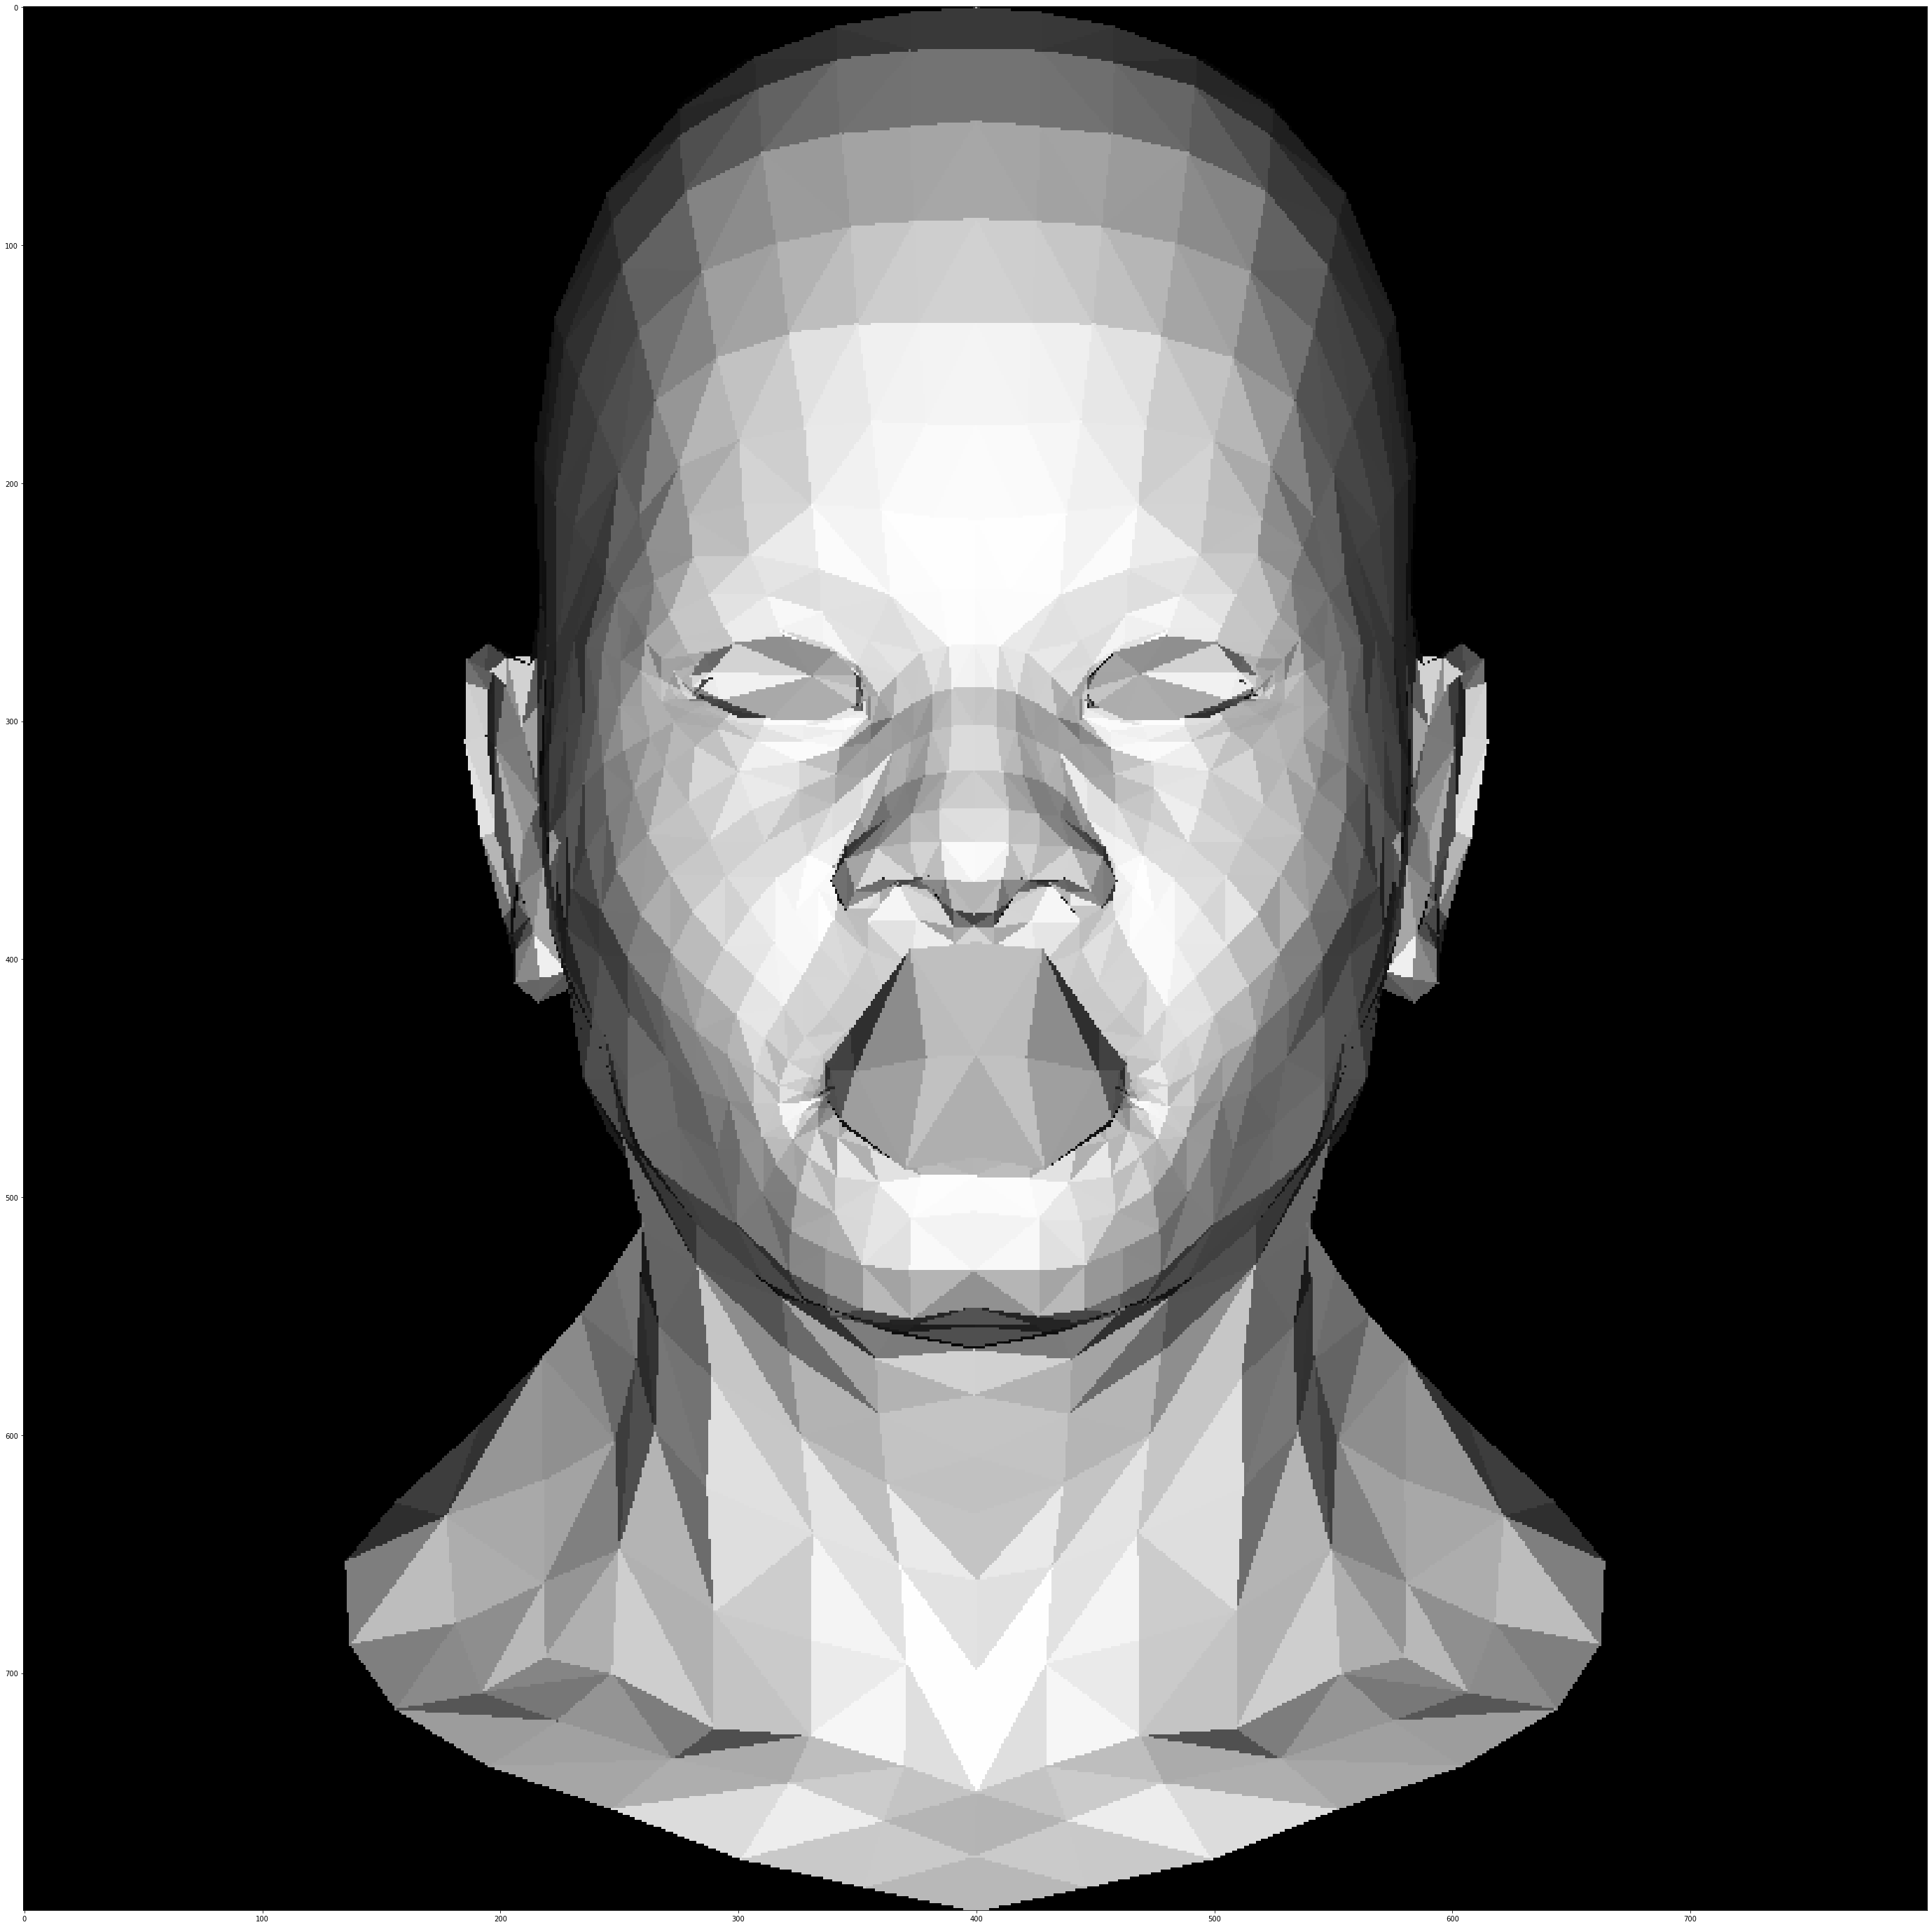

In [36]:
plt.figure(figsize=(50,50))
plt.imshow(plane.astype('int32'))

# Lesson 3

In [37]:
def fill_triangle(p0, p1, p2, z_buffer, plane, color):
    bbox_x, bbox_y = get_trian_bbox(p0[:2], p1[:2], p2[:2])

    try:
        precomp_t_inv = np.linalg.inv(np.array([
                [p0[0] - p2[0], p1[0] - p2[0]],
                [p0[1] - p2[1], p1[1] - p2[1]],]))
    except:
        return plane, z_buffer

    mesh_grid = np.meshgrid(np.arange(bbox_x[0], bbox_x[1]+1), 
                        np.arange(bbox_y[0], bbox_y[1]+1))

    grid = np.stack([mesh_grid[0].T, mesh_grid[1].T])
    grid = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T

    barycent = precomp_t_inv.dot(grid.T - np.array(p2[:2])[:,None])
    barycent = np.concatenate([barycent, 1-barycent.sum(axis=0)[None]])

    z_plane = (np.array([p0, p1, p2])[:,2][:,None] * barycent).sum(axis=0)

    good_pts = np.product(barycent>=0, axis=0)
    good_idx = grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]

    plane[good_idx[0], good_idx[1]] = np.where((z_buffer[good_idx[0], good_idx[1]] < z_plane[np.where(good_pts!=0)])[:,None],
                                                np.array([color]*len(good_idx[0])), plane[good_idx[0], good_idx[1]])
    
    z_buffer[good_idx[0], good_idx[1]] = np.where(z_buffer[good_idx[0], good_idx[1]] < z_plane[np.where(good_pts!=0)],
                                                z_plane[np.where(good_pts!=0)], z_buffer[good_idx[0], good_idx[1]])
    
    return plane, z_buffer

In [38]:
width  = 800;
height = 800;
plane = np.zeros((width,height,3))
light_dir = np.array([0,0,-1])
z_buffer = np.ones((width,height)) * (-np.inf)

In [39]:
triangles = parse_obj('obj/african_head.obj', False)

In [45]:
for cur_trian in triangles:
    for idx, cur_pts in enumerate(cur_trian):
        pt_1 = cur_pts[:]
        pt_2 = cur_trian[(idx+1)%3][:]
        
        pt_1[0] = int(pt_1[0] * width/2 + width/2)
        pt_2[0] = int(pt_2[0] * width/2 + width/2)
        
        pt_1[1] = - int(pt_1[1] * height/2 + height/2) 
        pt_2[1] = - int(pt_2[1] * height/2 + height/2)
        
        line(pt_1[::-1], pt_2[::-1], plane, white)

In [40]:
triangles = parse_obj('obj/african_head.obj', True)

In [47]:
for idx, cur_trian in enumerate(tqdm_notebook(triangles)):
    to_use_train = np.array(cur_trian)[:]
    norm = np.cross(to_use_train[2] - to_use_train[0], to_use_train[1] - to_use_train[0])
    norm = norm/np.linalg.norm(norm)   
    intens = (norm * light_dir).sum()
    intens = max(0, intens)
    
    cur_trian = np.array(cur_trian).tolist()
    
    if intens >= 0:
        for cur_idx in range(len(cur_trian)):
            cur_trian[cur_idx][0] = int((cur_trian[cur_idx][0] + 1) * width/2) 
            cur_trian[cur_idx][1] = - int((cur_trian[cur_idx][1] + 1) * height/2)
            cur_trian[cur_idx][0], cur_trian[cur_idx][1] = cur_trian[cur_idx][1], cur_trian[cur_idx][0]

        plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, [255*intens, 255*intens, 255*intens])
#         if idx > 50:
#             break

<ipython-input-47-725385d2947c>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cur_trian in enumerate(tqdm_notebook(triangles)):


In [41]:
for idx, cur_trian in enumerate(tqdm_notebook(triangles)):
    to_use_train = np.array(cur_trian)[:]
    norm = np.cross(to_use_train[2] - to_use_train[0], to_use_train[1] - to_use_train[0])
    norm = norm/np.linalg.norm(norm)   
    intens = (norm * light_dir).sum()
    intens = max(0, intens)
    
    cur_trian = np.array(cur_trian).tolist()
    
    if intens >= 0:
        for cur_idx in range(len(cur_trian)):
            cur_trian[cur_idx][0] = int((cur_trian[cur_idx][0] + 1) * width/2) 
            cur_trian[cur_idx][1] = - int((cur_trian[cur_idx][1] + 1) * height/2)
            cur_trian[cur_idx][0], cur_trian[cur_idx][1] = cur_trian[cur_idx][1], cur_trian[cur_idx][0]

        plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, [255*intens, 255*intens, 255*intens])
#         if idx > 50:
#             break

<ipython-input-41-725385d2947c>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cur_trian in enumerate(tqdm_notebook(triangles)):


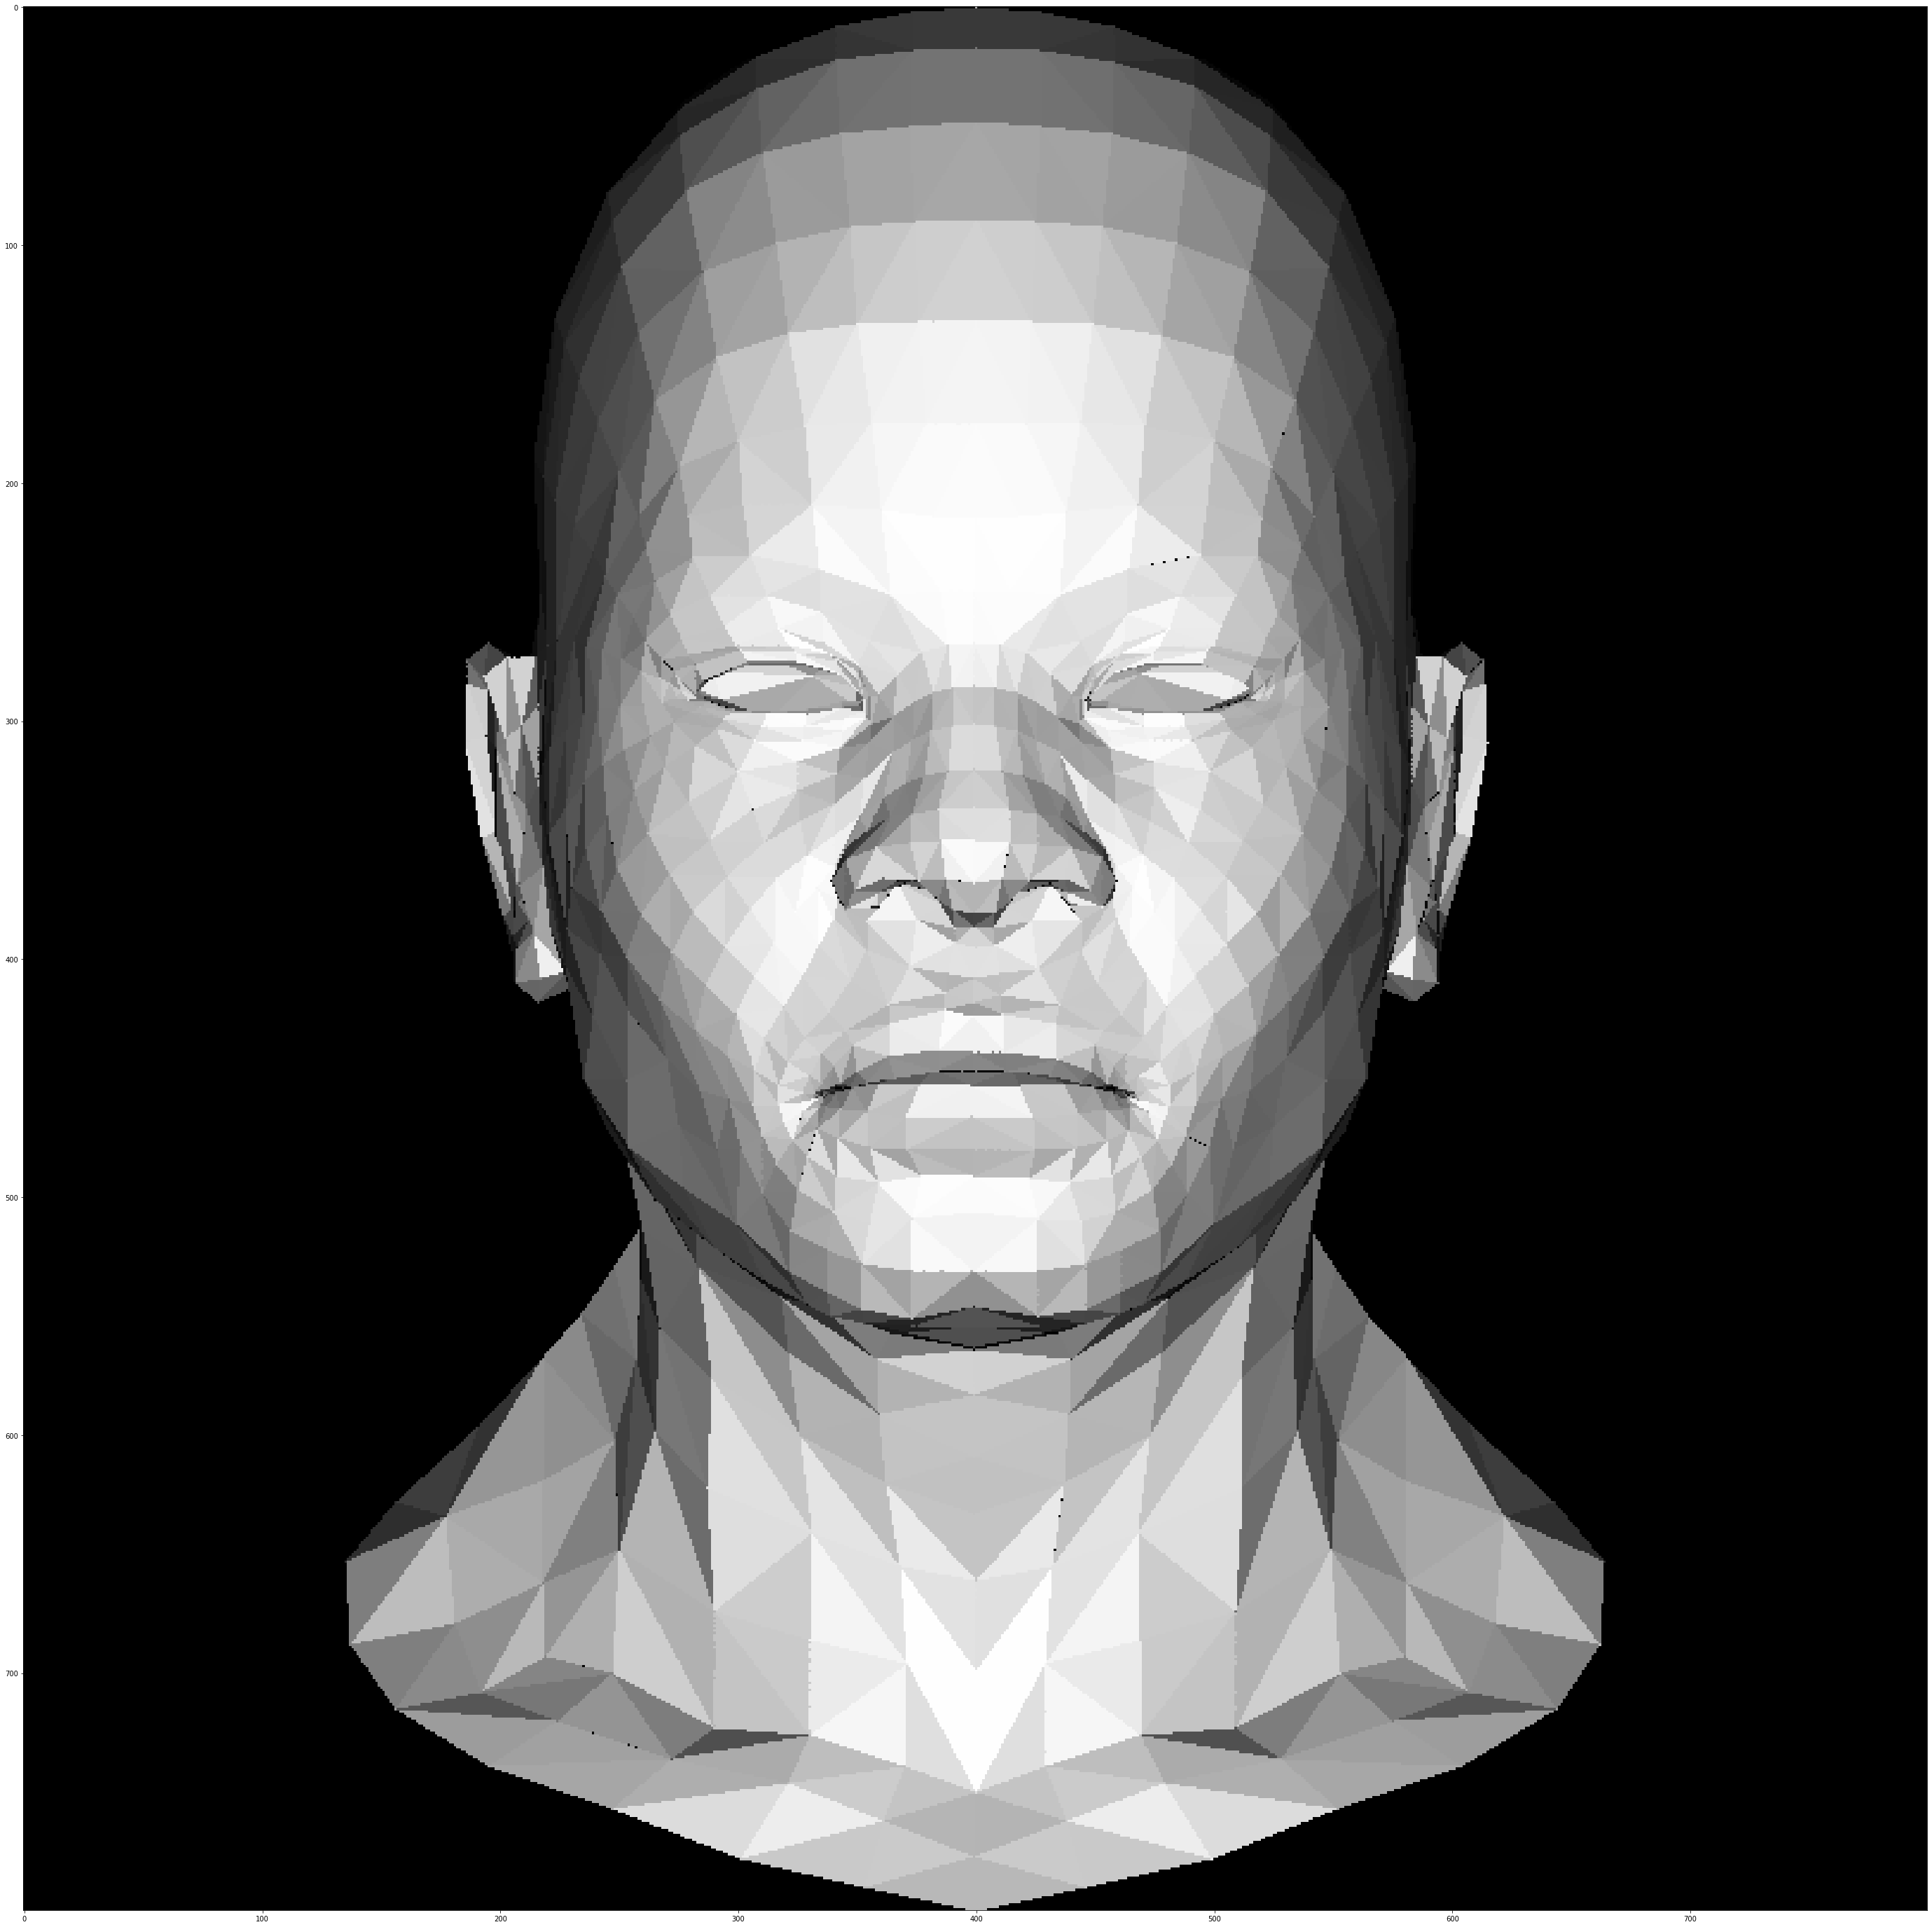

In [42]:
plt.figure(figsize=(50,50))
plt.imshow(plane.astype('int32'))

----

In [49]:
def plot_face_lines(path = 'obj/african_head.obj'):
    triangles = parse_obj(path, False)
    for cur_trian in triangles:
        for idx, cur_pts in enumerate(cur_trian):
            pt_1 = cur_pts[:]
            pt_2 = cur_trian[(idx+1)%3][:]

            pt_1[0] = int(pt_1[0] * width/2 + width/2)
            pt_2[0] = int(pt_2[0] * width/2 + width/2)

            pt_1[1] = - int(pt_1[1] * height/2 + height/2) 
            pt_2[1] = - int(pt_2[1] * height/2 + height/2)

            line(pt_1[::-1], pt_2[::-1], plane, white)
    return plane

In [50]:
def parse_obj(pth, return_z = False, return_text=False):

    with open(pth) as f:
        lines = f.readlines()

    vert = [x for x in lines if x.startswith('v ')]
    vert = [list(map(float, x[1:].strip().split())) for x in vert]

    text = [x for x in lines if x.startswith('vt ')]
    text = [list(map(float, x.strip().split()[1:-1])) for x in text]

    faces = [x for x in lines if x.startswith('f')]
    faces = [[x.split('/')[0].split()[1], x.split('/')[2].split()[1], x.split('/')[4].split()[1]]
             for x in faces]
    faces = [[int(y) - 1 for y in x] for x in faces]

    text_coord = [x for x in lines if x.startswith('f')]
    text_coord = [[x.split('/')[1], x.split('/')[3], x.split('/')[5] ]
                     for x in text_coord]
    text_coord = [[int(y) - 1 for y in x] for x in text_coord]


    triangles = []
    trian_text = []
    for cur_face, cur_texture in zip(faces, text_coord):
        pts = []
        pts_text = []
        for cur_vert, cur_one_text in zip(cur_face, cur_texture):
            pts_text.append(text[cur_one_text])
            if return_z:
                pts.append(vert[cur_vert])
            else:
                pts.append(vert[cur_vert][:-1])

        triangles.append(pts)
        trian_text.append(pts_text)

    if return_text:
        return triangles, trian_text
    else:
        return triangles

In [51]:
def fill_triangle(p0, p1, p2, z_buffer, plane, intens, color, texture=None):
    bbox_x, bbox_y = get_trian_bbox(p0[:2], p1[:2], p2[:2])

    try:
        precomp_t_inv = np.linalg.inv(np.array([
                [p0[0] - p2[0], p1[0] - p2[0]],
                [p0[1] - p2[1], p1[1] - p2[1]],]))
    except:
        return plane, z_buffer
    
    use_color = True if texture is None else False

    mesh_grid = np.meshgrid(np.arange(bbox_x[0], bbox_x[1]+1), 
                        np.arange(bbox_y[0], bbox_y[1]+1))

    grid = np.stack([mesh_grid[0].T, mesh_grid[1].T])
    grid = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T

    barycent = precomp_t_inv.dot(grid.T - np.array(p2[:2])[:,None])
    barycent = np.concatenate([barycent, 1-barycent.sum(axis=0)[None]])

    z_plane = (np.array([p0, p1, p2])[:,2][:,None] * barycent).sum(axis=0)

    good_pts = np.product(barycent>=0, axis=0)
    good_idx = grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]
    
    need_z_buffer_update = z_buffer[good_idx[0], good_idx[1]] < z_plane[np.where(good_pts!=0)]
    
    if use_color:
        plane[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update[:,None],
                                                   np.array([color]*len(good_idx[0])), 
                                                   plane[good_idx[0], good_idx[1]])
    else:
        color = color.T.dot(barycent).T
        color[:,0] *= texture.shape[0]
        color[:,1] *= texture.shape[1]
        color = color.astype('int32')
        
        to_use_texture = texture[-color[np.where(good_pts!=0)][:,1], 
                                 color[np.where(good_pts!=0)][:,0]][:,:-1]*intens
        
        plane[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update[:,None],
                                                   to_use_texture, 
                                                   plane[good_idx[0], good_idx[1]])
        
    
    z_buffer[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update,
                                                z_plane[np.where(good_pts!=0)], 
                                                z_buffer[good_idx[0], good_idx[1]])
    
    return plane, z_buffer

In [183]:
width  = 800;
height = 800;
plane = np.zeros((width,height,3))
light_dir = np.array([0,0,-1])
z_buffer = np.ones((width,height)) * (-np.inf)

In [184]:
# plane = plot_face_lines()

In [185]:
triangles, text_coord = parse_obj('obj/african_head.obj', return_z = True, return_text=True)
texture = imread('obj/african_head_diffuse.png')

In [186]:
triangles = np.array(triangles)
text_coord = np.array(text_coord)

norms = np.cross(triangles[:,2] - triangles[:,0], triangles[:,1] - triangles[:,0])
norms = norms/np.linalg.norm(norms, axis=-1)[:,None] 

intenses = (norms * light_dir[None]).sum(axis=-1)
intenses = np.maximum(0, intenses)

triangles = triangles * np.array([width/2, -height/2, 1])[None, None,:] + \
                        np.array([width/2, -height/2, 0])[None, None,:]

t = triangles[:,:,1].copy().astype('int32')
triangles[:,:,1] = triangles[:,:,0].astype('int32')
triangles[:,:,0] = t

In [188]:
for idx, (cur_trian, cur_text_coord) in enumerate(zip(triangles, text_coord)):
    cur_trian = cur_trian.tolist()
    cur_trian = [[int(x[0]), int(x[1]), x[2]] for x in cur_trian]
    
    plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, intenses[idx], cur_text_coord, texture)

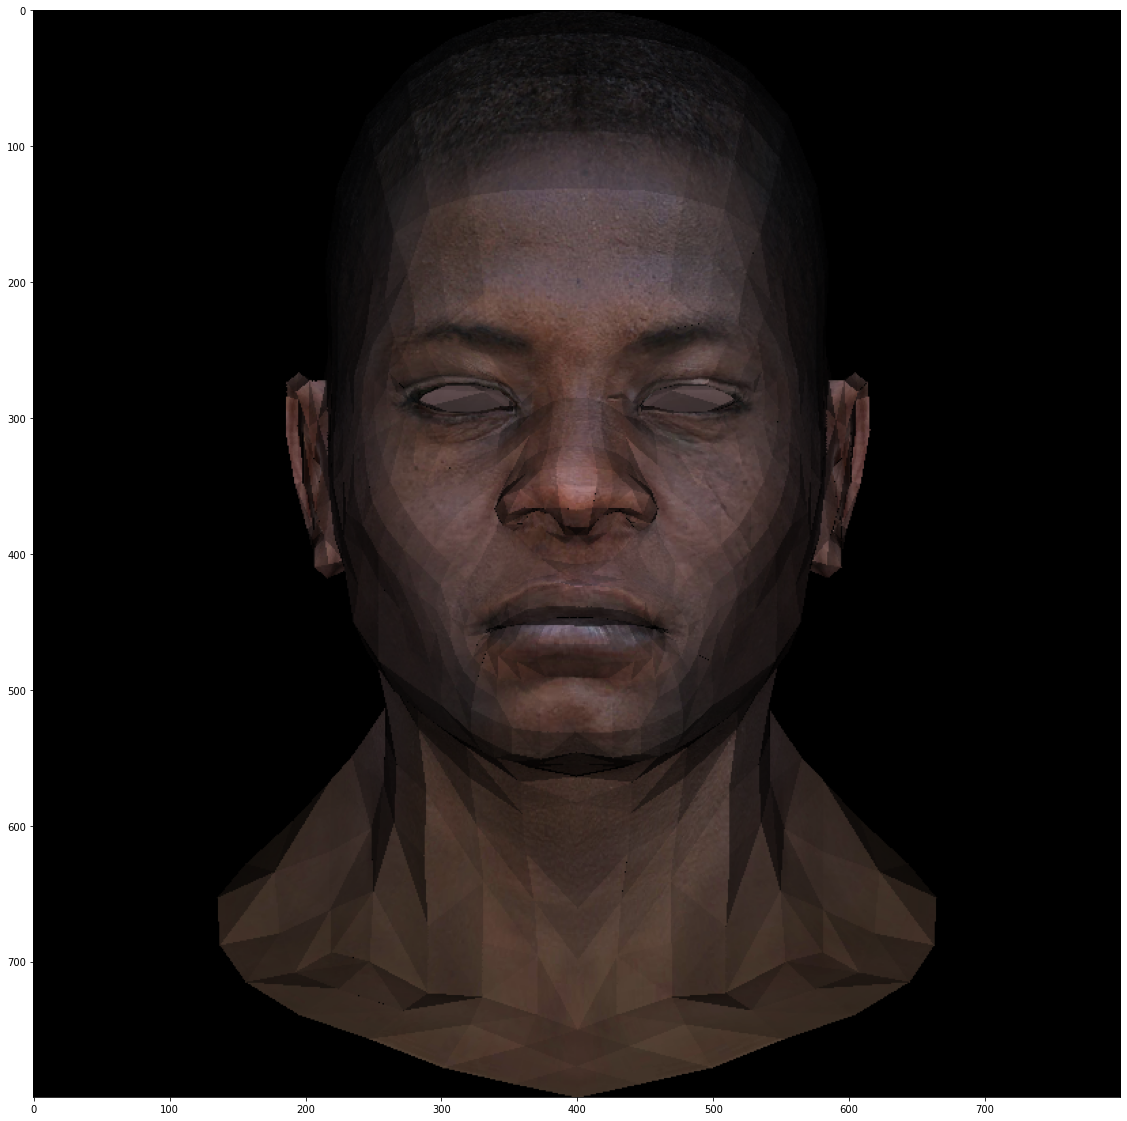

In [189]:
plt.figure(figsize=(20,20))
plt.imshow(plane.astype('int32'))

-----

# Lesson 4

In [12]:
width  = 800;
height = 800;
depth = 255
plane = np.zeros((width,height,3))
light_dir = np.array([0,0,-1])
z_buffer = np.ones((width,height)) * (-np.inf)
c = 3

In [13]:
intrinsic = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, -1/c, 1]
])

In [14]:
cur_width  = width * 2/3
cur_height = height * 2/3
cur_depth  = depth * 2/3

view_port = np.array([
    [cur_width/2, 0, 0, cur_width/2 + cur_width/4],
    
    [0, -cur_height/2, 0, -cur_height/2 - cur_height/4],
    
    [0, 0, cur_depth/2,  cur_depth/2],
    
    [0, 0, 0, 1],
])

In [15]:
# plane = plot_face_lines()

In [602]:
triangles, text_coord = parse_obj('obj/african_head.obj', return_z = True, return_text=True)
texture = imread('obj/african_head_diffuse.png')

In [603]:
triangles = np.array(triangles)
text_coord = np.array(text_coord)

In [604]:
norms = np.cross(triangles[:,2] - triangles[:,0], triangles[:,1] - triangles[:,0])
norms = norms/np.linalg.norm(norms, axis=-1)[:,None] 

intenses = (norms * light_dir[None]).sum(axis=-1)
intenses = np.maximum(0, intenses)

In [605]:
init_shape = triangles.shape
triangles = triangles.reshape(-1,3)

triangles = np.concatenate([triangles, np.ones((triangles.shape[0], 1))], axis=1)
triangles = intrinsic.dot(triangles.T).T

triangles = view_port.dot(triangles.T).T

triangles = (triangles/triangles[:,-1][:,None])[:,:-1]
triangles = triangles.reshape(init_shape)

In [606]:
t = triangles[:,:,1].copy().astype('int32')
triangles[:,:,1] = triangles[:,:,0].astype('int32')
triangles[:,:,0] = t

In [607]:
for idx, (cur_trian, cur_text_coord) in enumerate(zip(triangles, text_coord)):
    cur_trian = cur_trian.tolist()
    cur_trian = [[int(x[0]), int(x[1]), x[2]] for x in cur_trian]
    
    plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, intenses[idx], cur_text_coord, texture)

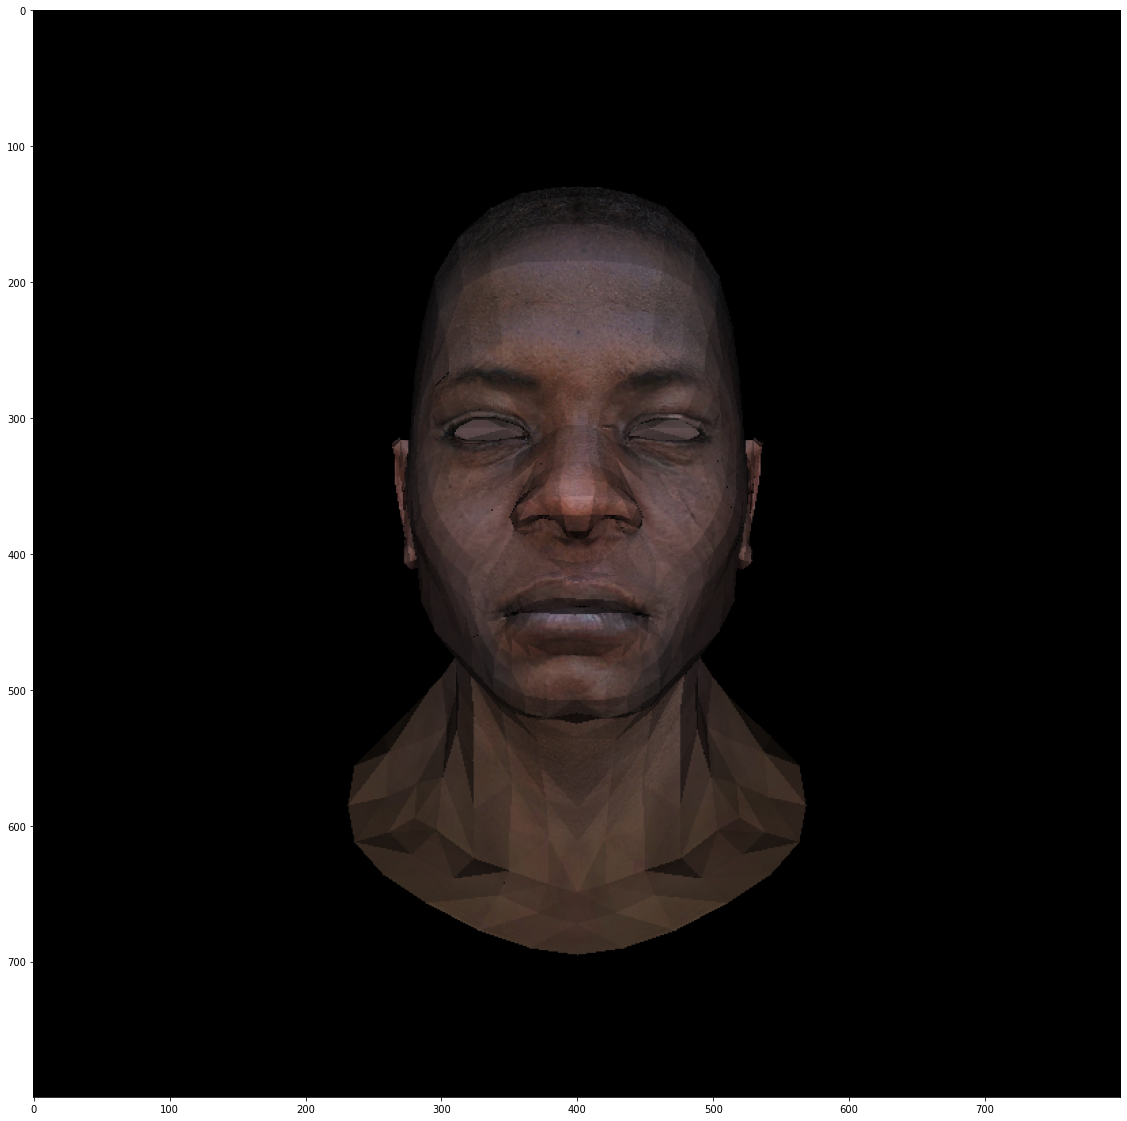

In [608]:
plt.figure(figsize=(20,20))
plt.imshow(plane.astype('int32'))

----

# Lesson 5

In [1223]:
def parse_obj(pth, return_z = False, return_text=False, return_normals=False):
    with open(pth) as f:
        lines = f.readlines()

    vert = [x for x in lines if x.startswith('v ')]
    vert = [list(map(float, x[1:].strip().split())) for x in vert]

    text = [x for x in lines if x.startswith('vt ')]
    text = [list(map(float, x.strip().split()[1:-1])) for x in text]

    norms = [x for x in lines if x.startswith('vn ')]
    norms = [list(map(float, x.strip().split()[1:])) for x in norms]

    faces = [x for x in lines if x.startswith('f')]
    faces = [[x.split('/')[0].split()[1], x.split('/')[2].split()[1], x.split('/')[4].split()[1]]
             for x in faces]
    faces = [[int(y) - 1 for y in x] for x in faces]

    text_coord = [x for x in lines if x.startswith('f')]
    text_coord = [[x.split('/')[1], x.split('/')[3], x.split('/')[5] ]
                     for x in text_coord]
    text_coord = [[int(y) - 1 for y in x] for x in text_coord]

    norm_coord = [x for x in lines if x.startswith('f')]
    norm_coord = [[x.split('/')[2].split(' ')[0], x.split('/')[4].split(' ')[0], x.split('/')[6].split(' ')[0].strip() ]
                     for x in norm_coord]
    norm_coord = [[int(y) - 1 for y in x] for x in norm_coord]


    triangles = []
    trian_text = []
    normals = []
    for cur_face, cur_texture, cur_norm in zip(faces, text_coord, norm_coord):
        pts = []
        pts_text = []
        pts_norm = []
        for cur_vert, cur_one_text, cur_one_norm in zip(cur_face, cur_texture, cur_norm):
            pts_text.append(text[cur_one_text])
            pts_norm.append(norms[cur_one_norm])
            if return_z:
                pts.append(vert[cur_vert])
            else:
                pts.append(vert[cur_vert][:-1])

        triangles.append(pts)
        trian_text.append(pts_text)
        normals.append(pts_norm)

    to_ret_vals = [triangles]
    if return_text:
        to_ret_vals.append(trian_text)
    if return_normals:
        to_ret_vals.append(normals)
    
    return to_ret_vals

In [1224]:
def fill_triangle(p0, p1, p2, z_buffer, plane, intens, color, texture=None, light_dir=None):
    bbox_x, bbox_y = get_trian_bbox(p0[:2], p1[:2], p2[:2])

    try:
        precomp_t_inv = np.linalg.inv(np.array([
                [p0[0] - p2[0], p1[0] - p2[0]],
                [p0[1] - p2[1], p1[1] - p2[1]],]))
    except:
        return plane, z_buffer
    
    use_color = True if texture is None else False
    simple_intense = True if isinstance(intens, float) else False

    mesh_grid = np.meshgrid(np.arange(bbox_x[0], bbox_x[1]+1), 
                        np.arange(bbox_y[0], bbox_y[1]+1))

    grid = np.stack([mesh_grid[0].T, mesh_grid[1].T])
    grid = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T

    barycent = precomp_t_inv.dot(grid.T - np.array(p2[:2])[:,None])
    barycent = np.concatenate([barycent, 1-barycent.sum(axis=0)[None]])

    z_plane = (np.array([p0, p1, p2])[:,2][:,None] * barycent).sum(axis=0)

    good_pts = np.product(barycent>=0, axis=0)
    good_idx = grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]
    
    need_z_buffer_update = z_buffer[good_idx[0], good_idx[1]] < z_plane[np.where(good_pts!=0)]
    
    if not simple_intense:
        intens = intens.T.dot(barycent).T
        intens = intens.dot(light_dir)
        intens = intens[np.where(good_pts!=0)][:,None]
        intens = np.maximum(0, intens)
            
    if use_color:
        plane[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update[:,None],
                                                   np.array([color]*len(good_idx[0]))*intens, 
                                                   plane[good_idx[0], good_idx[1]])
    else:
        color = color.T.dot(barycent).T
        color[:,0] *= texture.shape[0]
        color[:,1] *= texture.shape[1]
        color = color.astype('int32')
            
        to_use_texture = texture[-color[np.where(good_pts!=0)][:,1], 
                                 color[np.where(good_pts!=0)][:,0]][:,:-1]*intens
            

        plane[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update[:,None],
                                                   to_use_texture, 
                                                   plane[good_idx[0], good_idx[1]])
        
    
    z_buffer[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update,
                                                z_plane[np.where(good_pts!=0)], 
                                                z_buffer[good_idx[0], good_idx[1]])
    
    return plane, z_buffer

In [16]:
def get_lookat(eye, center, up):
    z = eye - center
    z = z/np.linalg.norm(z)

    x = np.cross(up, z)
    x = x/np.linalg.norm(x)

    y = np.cross(z, x)
    y = y/np.linalg.norm(y)
    
    minv = np.eye(4)
    tr = np.eye(4)
    minv[0][:-1] = x
    minv[1][:-1] = y
    minv[2][:-1] = z
    tr[:-1,3] = -center

    minv = minv.dot(tr)
    return minv

In [17]:
width  = 800;
height = 800;
depth = 255
eye = np.array([1,1,3]);
center = np.array([0,0,0])
up = np.array([0,1,0])

c = np.linalg.norm(eye-center)

plane = np.zeros((width,height,3))
light_dir = np.array([0,0,-1])
z_buffer = np.ones((width,height)) * (-np.inf)

In [18]:
intrinsic = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, -1/c, 1]
])

In [19]:
cur_width  = width * 2/3
cur_height = height * 2/3
cur_depth  = depth

view_port = np.array([
    [cur_width/2, 0, 0, cur_width/2 + cur_width/4],
    
    [0, -cur_height/2, 0, -cur_height/2 - cur_height/4],
    
    [0, 0, cur_depth/2,  cur_depth/2],
    
    [0, 0, 0, 1],
])

In [20]:
triangles, text_coord, norms = parse_obj('obj/african_head.obj', return_z = True, return_text=True, return_normals=True)
texture = imread('obj/african_head_diffuse.png')

NameError: name 'parse_obj' is not defined

In [1471]:
triangles = np.array(triangles)
text_coord = np.array(text_coord)
norms = -np.array(norms)

minv = get_lookat(eye, center, up)

In [1472]:
# init_shape = norms.shape
# norms = norms.reshape(-1,3)

# norms = np.concatenate([norms, np.ones((norms.shape[0], 1))], axis=1)

# all_tr = view_port.dot(intrinsic.dot(minv))
# all_tr = np.linalg.inv(all_tr.T)
# norms = all_tr.dot(norms.T).T

# norms = (norms/norms[:,-1][:,None])[:,:-1]
# norms = norms.reshape(init_shape)

In [1473]:
init_shape = triangles.shape
triangles = triangles.reshape(-1,3)

triangles = np.concatenate([triangles, np.ones((triangles.shape[0], 1))], axis=1)

triangles = view_port.dot(intrinsic.dot(minv.dot(triangles.T))).T
# triangles = intrinsic.dot(triangles.T).T
# triangles = view_port.dot(triangles.T).T

triangles = (triangles/triangles[:,-1][:,None])[:,:-1]
triangles = triangles.reshape(init_shape)

In [1474]:
t = triangles[:,:,1].copy().astype('int32')
triangles[:,:,1] = triangles[:,:,0].astype('int32')
triangles[:,:,0] = t

In [1475]:
for idx, (cur_trian, cur_text_coord, cur_norm) in enumerate(zip(triangles, text_coord, norms)):
    cur_trian = cur_trian.tolist()
    cur_trian = [[int(x[0]), int(x[1]), x[2]] for x in cur_trian]

    plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, cur_norm, cur_text_coord, texture, light_dir)
#     plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, cur_norm, [255,255,255], None, light_dir)

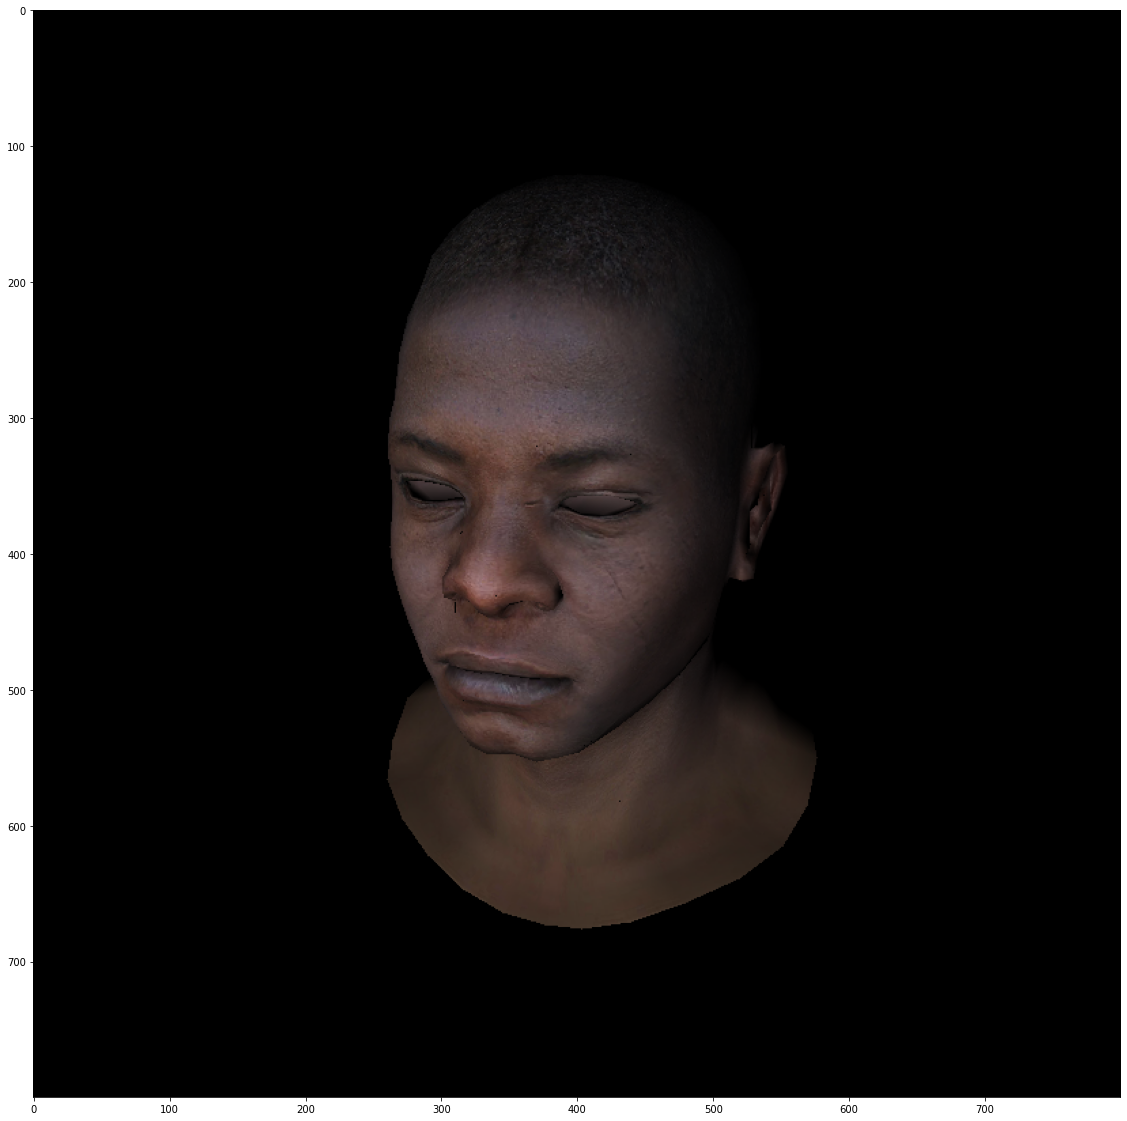

In [1476]:
plt.figure(figsize=(20,20))
plt.imshow(plane.astype('int32'))

---

# Lesson 6

In [21]:
def parse_obj(pth, return_z = False, return_text=False, return_normals=False):
    with open(pth) as f:
        lines = f.readlines()

    vert = [x for x in lines if x.startswith('v ')]
    vert = [list(map(float, x[1:].strip().split())) for x in vert]

    text = [x for x in lines if x.startswith('vt ')]
    text = [list(map(float, x.strip().split()[1:-1])) for x in text]

    norms = [x for x in lines if x.startswith('vn ')]
    norms = [list(map(float, x.strip().split()[1:])) for x in norms]

    faces = [x for x in lines if x.startswith('f')]
    faces = [[x.split('/')[0].split()[1], x.split('/')[2].split()[1], x.split('/')[4].split()[1]]
             for x in faces]
    faces = [[int(y) - 1 for y in x] for x in faces]

    text_coord = [x for x in lines if x.startswith('f')]
    text_coord = [[x.split('/')[1], x.split('/')[3], x.split('/')[5] ]
                     for x in text_coord]
    text_coord = [[int(y) - 1 for y in x] for x in text_coord]

    norm_coord = [x for x in lines if x.startswith('f')]
    norm_coord = [[x.split('/')[2].split(' ')[0], x.split('/')[4].split(' ')[0], x.split('/')[6].split(' ')[0].strip() ]
                     for x in norm_coord]
    norm_coord = [[int(y) - 1 for y in x] for x in norm_coord]


    triangles = []
    trian_text = []
    normals = []
    for cur_face, cur_texture, cur_norm in zip(faces, text_coord, norm_coord):
        pts = []
        pts_text = []
        pts_norm = []
        for cur_vert, cur_one_text, cur_one_norm in zip(cur_face, cur_texture, cur_norm):
            pts_text.append(text[cur_one_text])
            pts_norm.append(norms[cur_one_norm])
            if return_z:
                pts.append(vert[cur_vert])
            else:
                pts.append(vert[cur_vert][:-1])

        triangles.append(pts)
        trian_text.append(pts_text)
        normals.append(pts_norm)

    to_ret_vals = [triangles]
    if return_text:
        to_ret_vals.append(trian_text)
    if return_normals:
        to_ret_vals.append(normals)
    
    return to_ret_vals

In [22]:
def fill_triangle(p0, p1, p2, z_buffer, plane, intens, color, texture=None, light_dir=None):
    bbox_x, bbox_y = get_trian_bbox(p0[:2], p1[:2], p2[:2])

    try:
        precomp_t_inv = np.linalg.inv(np.array([
                [p0[0] - p2[0], p1[0] - p2[0]],
                [p0[1] - p2[1], p1[1] - p2[1]],]))
    except:
        return plane, z_buffer
    
    use_color = True if texture is None else False
    simple_intense = True if isinstance(intens, float) else False

    mesh_grid = np.meshgrid(np.arange(bbox_x[0], bbox_x[1]+1), 
                        np.arange(bbox_y[0], bbox_y[1]+1))

    grid = np.stack([mesh_grid[0].T, mesh_grid[1].T])
    grid = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T

    barycent = precomp_t_inv.dot(grid.T - np.array(p2[:2])[:,None])
    barycent = np.concatenate([barycent, 1-barycent.sum(axis=0)[None]])

    z_plane = (np.array([p0, p1, p2])[:,2][:,None] * barycent).sum(axis=0)

    good_pts = np.product(barycent>=0, axis=0)
    good_idx = grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]
    
    need_z_buffer_update = z_buffer[good_idx[0], good_idx[1]] < z_plane[np.where(good_pts!=0)]
    
    if not simple_intense:
        intens = intens.T.dot(barycent).T
        intens = intens.dot(light_dir)
        intens = intens[np.where(good_pts!=0)][:,None]
        intens = np.maximum(0, intens)
            
    if use_color:
        plane[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update[:,None],
                                                   np.array([color]*len(good_idx[0]))*intens, 
                                                   plane[good_idx[0], good_idx[1]])
    else:
        color = color.T.dot(barycent).T
        color[:,0] *= texture.shape[0]
        color[:,1] *= texture.shape[1]
        color = color.astype('int32')
            
        to_use_texture = texture[-color[np.where(good_pts!=0)][:,1], 
                                 color[np.where(good_pts!=0)][:,0]][:,:-1]*intens
            

        plane[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update[:,None],
                                                   to_use_texture, 
                                                   plane[good_idx[0], good_idx[1]])
        
    
    z_buffer[good_idx[0], good_idx[1]] = np.where(need_z_buffer_update,
                                                z_plane[np.where(good_pts!=0)], 
                                                z_buffer[good_idx[0], good_idx[1]])
    
    return plane, z_buffer

In [23]:
def get_ModelView(eye, center, up):
    z = eye - center
    z = z/np.linalg.norm(z)

    x = np.cross(up, z)
    x = x/np.linalg.norm(x)

    y = np.cross(z, x)
    y = y/np.linalg.norm(y)
    
    minv = np.eye(4)
    tr = np.eye(4)
    minv[0][:-1] = x
    minv[1][:-1] = y
    minv[2][:-1] = z
    tr[:-1,3] = -center

    minv = minv.dot(tr)
    return minv

In [24]:
width  = 800;
height = 800;
depth = 255
eye = np.array([1,1,3]);
center = np.array([0,0,0])
up = np.array([0,1,0])

c = np.linalg.norm(eye-center)

plane = np.zeros((width,height,3))
light_dir = np.array([0,0,-1])
z_buffer = np.ones((width,height)) * (-np.inf)

In [25]:
intrinsic = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, -1/c, 1]
])

In [26]:
cur_width  = width * 2/3
cur_height = height * 2/3
cur_depth  = depth

view_port = np.array([
    [cur_width/2, 0, 0, cur_width/2 + cur_width/4],
    
    [0, -cur_height/2, 0, -cur_height/2 - cur_height/4],
    
    [0, 0, cur_depth/2,  cur_depth/2],
    
    [0, 0, 0, 1],
])

In [1522]:
triangles, text_coord, norms = parse_obj('obj/african_head.obj', return_z = True, return_text=True, return_normals=True)
texture = imread('obj/african_head_diffuse.png')

In [1523]:
triangles = np.array(triangles)
text_coord = np.array(text_coord)
norms = -np.array(norms)

minv = get_ModelView(eye, center, up)

In [1504]:
# init_shape = norms.shape
# norms = norms.reshape(-1,3)

# norms = np.concatenate([norms, np.ones((norms.shape[0], 1))], axis=1)

# all_tr = view_port.dot(intrinsic.dot(minv))
# all_tr = np.linalg.inv(all_tr.T)
# norms = all_tr.dot(norms.T).T

# norms = (norms/norms[:,-1][:,None])[:,:-1]
# norms = norms.reshape(init_shape)

In [1524]:
init_shape = triangles.shape
triangles = triangles.reshape(-1,3)

triangles = np.concatenate([triangles, np.ones((triangles.shape[0], 1))], axis=1)

triangles = view_port.dot(intrinsic.dot(minv.dot(triangles.T))).T
# triangles = intrinsic.dot(triangles.T).T
# triangles = view_port.dot(triangles.T).T

triangles = (triangles/triangles[:,-1][:,None])[:,:-1]
triangles = triangles.reshape(init_shape)

In [1525]:
t = triangles[:,:,1].copy().astype('int32')
triangles[:,:,1] = triangles[:,:,0].astype('int32')
triangles[:,:,0] = t

In [1507]:
for idx, (cur_trian, cur_text_coord, cur_norm) in enumerate(zip(triangles, text_coord, norms)):
    cur_trian = cur_trian.tolist()
    cur_trian = [[int(x[0]), int(x[1]), x[2]] for x in cur_trian]

    plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, cur_norm, cur_text_coord, texture, light_dir)
#     plane, z_buffer = fill_triangle(*cur_trian, z_buffer, plane, cur_norm, [255,255,255], None, light_dir)

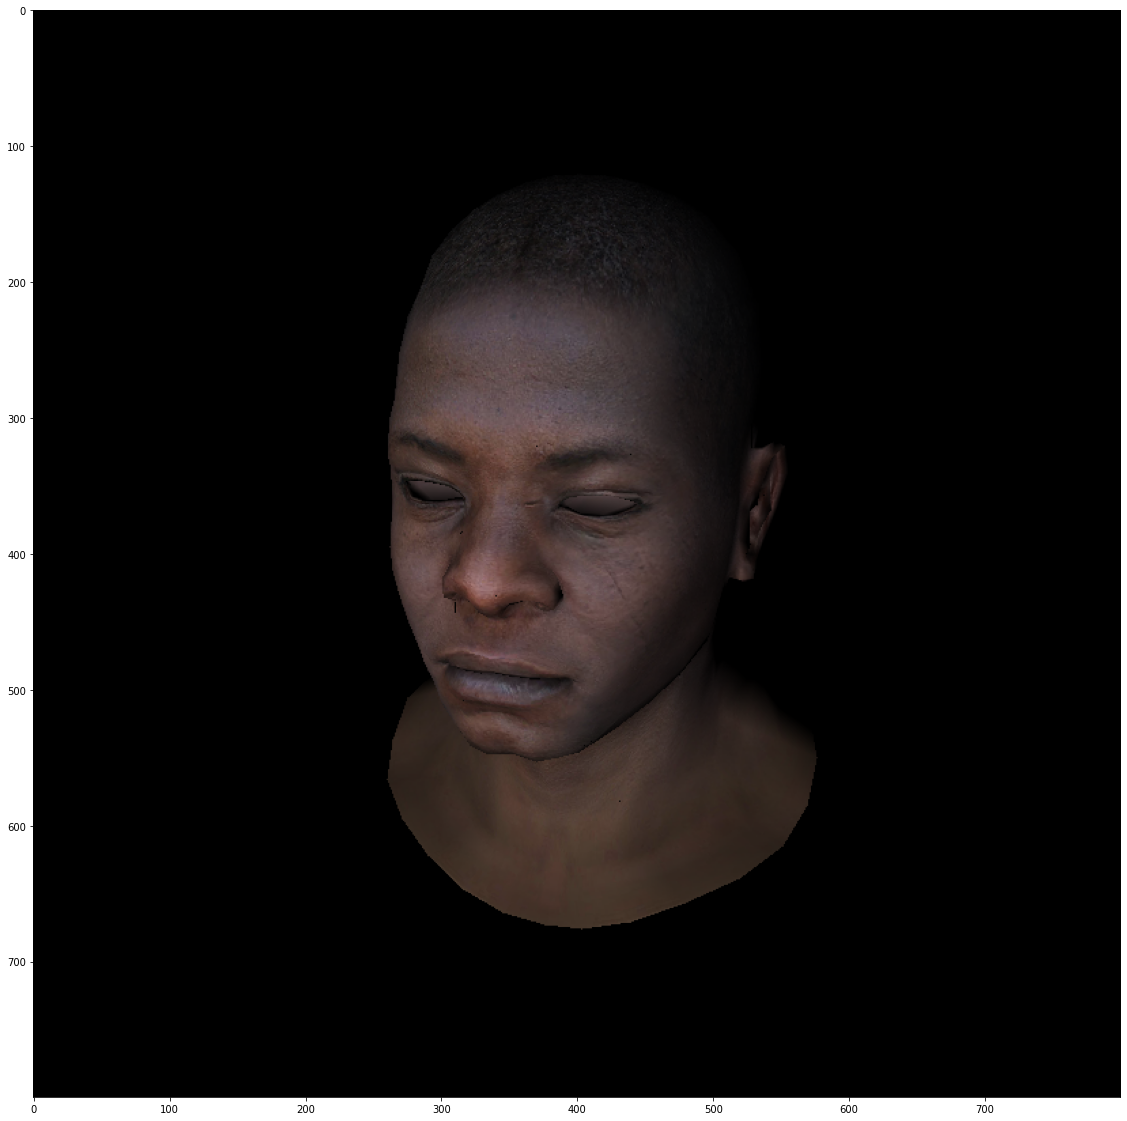

In [1508]:
plt.figure(figsize=(20,20))
plt.imshow(plane.astype('int32'))

----

In [33]:
class Model():
    def __init__(self, obj_path, text_path):
        self.obj_path = obj_path
        self.text_path = text_path
        
        self.triangles = None
        self.texture_coord = None
        self.texture = None
        self.norms = None
        
        self.read_obj(self.obj_path)
        if text_path is not None:
            self.texture = imread(self.text_path)[:,:,:3]
    
    def read_obj(self, obj_path):
        with open(obj_path) as f:
            lines = f.readlines()

        vert = [x for x in lines if x.startswith('v ')]
        vert = [list(map(float, x[1:].strip().split())) for x in vert]

        text = [x for x in lines if x.startswith('vt ')]
        text = [list(map(float, x.strip().split()[1:-1])) for x in text]

        norms = [x for x in lines if x.startswith('vn ')]
        norms = [list(map(float, x.strip().split()[1:])) for x in norms]

        faces = [x for x in lines if x.startswith('f')]
        faces = [[x.split('/')[0].split()[1], x.split('/')[2].split()[1], x.split('/')[4].split()[1]]
                 for x in faces]
        faces = [[int(y) - 1 for y in x] for x in faces]

        text_coord = [x for x in lines if x.startswith('f')]
        text_coord = [[x.split('/')[1], x.split('/')[3], x.split('/')[5] ]
                         for x in text_coord]
        text_coord = [[int(y) - 1 for y in x] for x in text_coord]

        norm_coord = [x for x in lines if x.startswith('f')]
        norm_coord = [[x.split('/')[2].split(' ')[0], x.split('/')[4].split(' ')[0], x.split('/')[6].split(' ')[0].strip() ]
                         for x in norm_coord]
        norm_coord = [[int(y) - 1 for y in x] for x in norm_coord]


        triangles = []
        trian_text = []
        normals = []
        for cur_face, cur_texture, cur_norm in zip(faces, text_coord, norm_coord):
            pts = []
            pts_text = []
            pts_norm = []
            for cur_vert, cur_one_text, cur_one_norm in zip(cur_face, cur_texture, cur_norm):
                pts_text.append(text[cur_one_text])
                pts_norm.append(norms[cur_one_norm])
                pts.append(vert[cur_vert])

            triangles.append(pts)
            trian_text.append(pts_text)
            normals.append(pts_norm)
        
        self.triangles = np.array(triangles)
        self.texture_coord = np.array(trian_text)
        self.norms = -np.array(normals)

In [34]:
def barycentric_transform(points, grid):
    try:
        precomp_t_inv = np.linalg.inv(np.array([
                    [points[0][0] - points[2][0], points[1][0] - points[2][0]],
                    [points[0][1] - points[2][1], points[1][1] - points[2][1]],]))
    except:
        return None
    
    barycent = precomp_t_inv.dot(grid.T - points[2][:2][:,None])
    barycent = np.concatenate([barycent, 1-barycent.sum(axis=0)[None]])
    return barycent

def triangle(points, shader, plane, z_buffer):
    bbox_x, bbox_y = get_trian_bbox(points[0][:2]/points[0][3], 
                                    points[1][:2]/points[1][3], 
                                    points[2][:2]/points[2][3])
    
    mesh_grid = np.meshgrid(np.arange(bbox_x[0], bbox_x[1]+1), 
                        np.arange(bbox_y[0], bbox_y[1]+1))

    grid = np.stack([mesh_grid[0].T, mesh_grid[1].T])
    grid = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T
    
    barycent = barycentric_transform((points/points[:,3][:,None]).astype('int32'), grid)
    
    if barycent is None:
        return plane, z_buffer
    
    z_plane = (points[:,2][:,None] * barycent).sum(axis=0)
    w_plane = (points[:,3][:,None] * barycent).sum(axis=0)
    z_plane /= w_plane
    
    good_pts = np.product(barycent>=0, axis=0)
    good_idx = grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]
    
    if np.sum(good_pts) == 0:
        return plane, z_buffer
    
    need_z_buffer_update = z_buffer[good_idx[0], good_idx[1]] < z_plane[np.where(good_pts!=0)]
    
    good_pts[good_pts!=0] = need_z_buffer_update
    good_idx = grid[np.where(good_pts!=0)][:,0], grid[np.where(good_pts!=0)][:,1]
    
    if np.sum(good_idx) == 0:
        return plane, z_buffer

    color = []
    for cur_bar in barycent.T[np.where(good_pts != 0)]:
        color.append(shader.fragment(cur_bar))
    color = np.array(color)
    
    plane[good_idx[0], good_idx[1]] = color
    
    z_buffer[good_idx[0], good_idx[1]] = z_plane[np.where(good_pts!=0)]
    
    return plane, z_buffer

In [62]:
class GouraudShader():    
    var_intens = np.zeros(3)
    var_text_coord = np.zeros((3,2))
    
    def __init__(self, model, view_port, intrinsic, minv, light_dir):
        self.view_port = view_port
        self.intrinsic = intrinsic
        self.minv = minv
        self.model = model
        self.light_dir = light_dir
    
    def add_1_to_vert(self, vert):
        vert = np.concatenate((vert, [1]))
        return vert
    
    def vertex(self, iface, nth_vert):
        self.var_intens[nth_vert] = np.maximum(0, (model.norms[iface, nth_vert]*self.light_dir).sum())
        self.var_text_coord[nth_vert] = model.texture_coord[iface, nth_vert] * [model.texture.shape[1], 
                                                                                model.texture.shape[0]]
        cur_vert = self.add_1_to_vert(model.triangles[iface, nth_vert])
        cur_vert = self.view_port.dot(self.intrinsic.dot(self.minv.dot(cur_vert.T)))
        return cur_vert
        
    
    def fragment(self, bar):
        intense = self.var_intens.dot(bar)
#         color = np.array([255, 255, 255]) * intense
        text_coord = self.var_text_coord.T.dot(bar).astype('int32')
#         print(self.var_text_coord)
        color = model.texture[-text_coord[1], text_coord[0]]
#         print(color)
#         print('---')
        
        return color

In [63]:
plane = np.zeros((width,height,3))
z_buffer = np.ones((width,height)) * (-np.inf)

In [64]:
model = Model('obj/african_head.obj', 'obj/african_head_diffuse.png')

In [65]:
%%time
shader = GouraudShader(model, view_port, intrinsic, minv, light_dir)

for i in range(len(model.triangles)):
    cur_trian = []
    for j in range(3):
        cur_trian.append(shader.vertex(i, j))
        
    cur_trian = np.array([[x[1], x[0], x[2], x[3]] for x in cur_trian])
    
    plane, z_buffer = triangle(np.array(cur_trian), shader, plane, z_buffer)
    

CPU times: user 1min 10s, sys: 3.94 s, total: 1min 14s
Wall time: 3.3 s


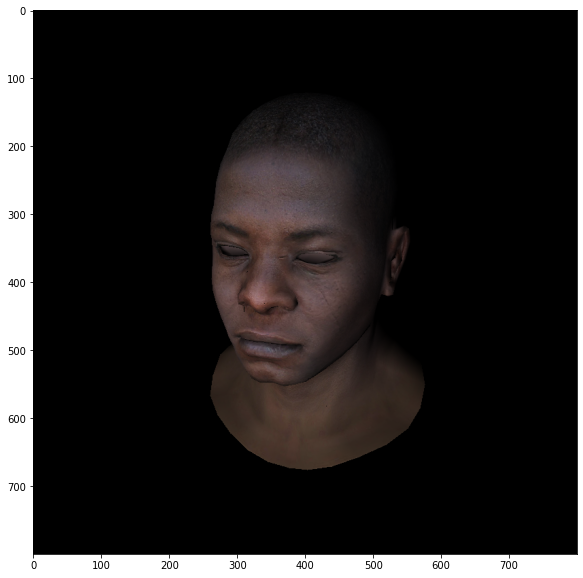

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(plane.astype('int32'))

In [39]:
def get_ModelView(eye, center, up):
    z = eye - center
    z = z/np.linalg.norm(z)

    x = np.cross(up, z)
    x = x/np.linalg.norm(x)

    y = np.cross(z, x)
    y = y/np.linalg.norm(y)
    
    minv = np.eye(4)
    tr = np.eye(4)
    minv[0][:-1] = x
    minv[1][:-1] = y
    minv[2][:-1] = z
    tr[:-1,3] = -center

    minv = minv.dot(tr)
    return minv

In [43]:
width  = 800;
height = 800;
depth = 255
eye = np.array([1,1,3]);
center = np.array([0,0,0])
up = np.array([0,1,0])

c = np.linalg.norm(eye-center)

plane = np.zeros((width,height,3))
light_dir = np.array([0,0,-1])
z_buffer = np.ones((width,height)) * (-np.inf)
minv = get_ModelView(eye, center, up)

In [41]:
intrinsic = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, -1/c, 1]
])

In [42]:
cur_width  = width * 2/3
cur_height = height * 2/3
cur_depth  = depth

view_port = np.array([
    [cur_width/2, 0, 0, cur_width/2 + cur_width/4],
    
    [0, -cur_height/2, 0, -cur_height/2 - cur_height/4],
    
    [0, 0, cur_depth/2,  cur_depth/2],
    
    [0, 0, 0, 1],
])

In [ ]:
cv2.imwrite()